### MAIN CODE

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [2]:
ELEMENT_TO_ATOMIC_NUMBER = {'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10}

In [3]:
def generate_CM(coordinates, element_symbols, pad=29):
    """
    Generates a padded Coulomb Matrix for a molecule.

    Parameters:
    - coordinates (numpy.ndarray): Nx3 array of atomic coordinates.
    - element_symbols (list of str): List of element symbols (e.g., ['C', 'H', 'O']).
    - pad (int): The size to pad the CM to (default is 29).

    Returns:
    - sorted_mat_flattened (numpy.ndarray): Flattened padded Coulomb Matrix.
    """
    size = len(element_symbols)
    cm = np.zeros((pad, pad))

    # Convert element symbols to atomic numbers
    try:
        atomic_numbers = [ELEMENT_TO_ATOMIC_NUMBER[elem] for elem in element_symbols]
    except KeyError as e:
        print(f"Unknown element symbol: {e}. Assigning atomic number 0.")
        atomic_numbers = [ELEMENT_TO_ATOMIC_NUMBER.get(elem, 0) for elem in element_symbols]

    # Fill the Coulomb Matrix
    for i in range(size):
        for j in range(size):
            if i == j:
                cm[i, j] = 0.5 * (atomic_numbers[i] ** 2.4)
            else:
                dist = np.linalg.norm(coordinates[i, :] - coordinates[j, :])
                if dist == 0:
                    cm[i, j] = 0  # Handle division by zero
                else:
                    cm[i, j] = (atomic_numbers[i] * atomic_numbers[j]) / dist

    # Sort the CM by the L1 norm of its rows in descending order
    row_norms = np.sum(cm,axis=1)
    sorted_indices = np.argsort(-row_norms) # argsort - the indices of these elements in the original array
    sorted_mat = cm[sorted_indices]

    # Flatten the sorted, padded CM
    return sorted_mat.ravel()

In [4]:
def parse_xyz_files(xyz_dir, pad=30):
    """
    Parses all .xyz files in a directory to generate Coulomb Matrices and extract U0 properties.

    Parameters:
    - xyz_dir (str): Path to the directory containing .xyz files.
    - pad (int): The size to pad the CM to.

    Returns:
    - X (numpy.ndarray): Feature matrix of shape (n_samples, pad*pad).
    - y (numpy.ndarray): Target vector containing U0 values.
    """
    # Initialize lists to store features and targets
    X = []
    y = []

    # Define the path pattern for .xyz files
    xyz_pattern = os.path.join(xyz_dir, '*.xyz')
    xyz_files = glob.glob(xyz_pattern)
    xyz_files.sort() # sort the list by file number
    # OR --> xyz_files = sorted(xyz_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1]))  

    if not xyz_files:
        print(f"No .xyz files found in directory: {xyz_dir}")
        return np.array(X), np.array(y)

    print(f"Found {len(xyz_files)} .xyz files. Processing...")

    for file in tqdm(xyz_files, desc="Processing .xyz files"):
        try:
            with open(file, 'r') as f:
                lines = f.readlines()

            # Replace '*^' with 'e' to match Python's float format
            for i, line in enumerate(lines):
                lines[i] = line.replace('*^', 'e')  # This updates lines[i] directly

            # Line 1: Number of atoms
            num_atoms = int(lines[0].strip())

            # Line 2: Properties
            properties = lines[1].strip().split()
            if len(properties) < 17:
                print(f"Warning: Insufficient properties in file {file}. Skipping.")
                continue

            # Extract U0 (13th property, zero-based index 12)
            U0 = float(properties[12])

            # Lines 3 to na+2: Element type, coordinates, and Mulliken partial charge
            element_symbols = []
            coordinates = []

            for line in lines[2:2 + num_atoms]:
                parts = line.strip().split()
                if len(parts) < 4:
                    print(f"Warning: Incomplete atom data in file {file}. Skipping.")
                    continue
                element = parts[0]
                x, y_coord, z = map(float, parts[1:4])
                element_symbols.append(element)
                coordinates.append([x, y_coord, z])

            # Convert lists to numpy arrays
            coordinates = np.array(coordinates)

            # Generate the padded, flattened CM
            cm_vector = generate_CM(coordinates, element_symbols, pad=pad)

            # Append to the dataset
            X.append(cm_vector)
            y.append(U0)

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(f"Generated feature matrix X with shape: {X.shape}")
    print(f"Generated target vector y with shape: {y.shape}")

    return X, y

In [5]:
def split_dataset(X, y, train_size=0.1, random_state=42):
    """
    Splits the dataset into training and testing sets.

    Parameters:
    - X (numpy.ndarray): Feature matrix.
    - y (numpy.ndarray): Target vector.
    - train_size (float): Proportion of the dataset to include in the training set.
    - random_state (int): Seed used by the random number generator.

    Returns:
    - X_train (numpy.ndarray): Training feature matrix.
    - X_test (numpy.ndarray): Testing feature matrix.
    - y_train (numpy.ndarray): Training target vector.
    - y_test (numpy.ndarray): Testing target vector.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    return X_train, X_test, y_train, y_test

In [18]:
def normalize_features(X_train, X_test, checker_model = 'gaussian'):
    """
    Normalizes the feature vectors using Euclidean norm for Gaussian kernel.

    Parameters:
    - X_train (numpy.ndarray): Training feature matrix.
    - X_test (numpy.ndarray): Testing feature matrix.

    Returns:
    - X_train_norm (numpy.ndarray): Normalized training feature matrix.
    - X_test_norm (numpy.ndarray): Normalized testing feature matrix
    """
    # mean_norm = 0.0 # how to define zero in np.float64
    # for m in X_train:
    #     mean_norm += np.linalg.norm(m)
    # mean_norm = mean_norm/X_train.shape[0]
    
    if checker_model == 'gaussian':  # Gaussian kernel
        # Compute mean Euclidean norm across training samples
        mean_norm = np.mean(np.linalg.norm(X_train, axis=1)) 
        print(f'mean_norm: {mean_norm}') 
    else:  # Laplacian kernel
        # Compute mean Manhattan norm across training samples
        mean_norm = np.mean(np.sum(np.abs(X_train), axis=1))
        print(f'mean_norm: {mean_norm}')
    
    # Normalize feature vectors
    X_train_norm = X_train / mean_norm
    X_test_norm = X_test / mean_norm
    
    return X_train_norm, X_test_norm
    
    # scaler = StandardScaler() # uses `z = (x - u) / s` formula
    # X_train_norm = scaler.fit_transform(X_train)
    # X_test_norm = scaler.transform(X_test)

In [7]:
def train_krr_model(X_train, y_train, alpha=1e-10, cv_folds=10, model_checker='gaussian'):
    """
    Trains a Kernel Ridge Regression model using GridSearchCV to find the best gamma.

    Parameters:
    - X_train (numpy.ndarray): Normalized training feature matrix.
    - y_train (numpy.ndarray): Training target vector.
    - alpha (float): Regularization parameter.
    - cv_folds (int): Number of cross-validation folds.

    Returns:
    - best_krr (KernelRidge): Trained KRR model with the best gamma.
    - best_params (dict): Best parameters found during grid search.
    """
    
    if(model_checker == 'gaussian'):
        # note use 2.0 instead of 2 to avoid type conversion issues
        # bandwidth = 2.0 ** np.arange(-2, 14, 1)  # [0.25, 0.5, 1, 2, ..., 4096, 8192] (base-2 logarithmic grid from 0.25 to 8192)
        kernel_width = np.logspace(np.log2(0.25), np.log2(8192), num=16, base=2)
        gamma_values = 1 / (2 * kernel_width ** 2) # gamma = 1 / 2 * (h**2)
        param_grid = {'gamma': gamma_values}

        # Instantiate the KRR model
        model_checked = KernelRidge(kernel='rbf', alpha=alpha)
    else:
        # For Laplacian kernel (from 0.1 to 16384)
        # laplacian_grid = 2.0 ** np.arange(-3.32192809, 14, 1)  # -3.32192809 is log2(0.1)

        # OR taking 0.0625 ~= 0.1
        kernel_width = np.logspace(np.log2(0.0625), np.log2(16384), num=19, base=2) # [(~= 0.1), 0.25, 0.5, 1.0, ..., 8192, 16384] (base-2 logarithmic grid from 0.1 to 16384)
        gamma_values = 1 / kernel_width # gamma = 1 / h
        param_grid = {'gamma': gamma_values}

        # Instantiate the KRR model
        model_checked = KernelRidge(kernel ='laplacian', alpha=alpha) 

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_checked,
        param_grid=param_grid,
        cv=cv_folds,
        # scoring='neg_mean_squared_error',
        # verbose=2
    )

    # Fit GridSearchCV
    print("Starting Grid Search for gamma...")
    grid_search.fit(X_train, y_train)

    # Retrieve the best model
    best_krr = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best gamma found: {best_params['gamma']}")

    return best_krr, best_params


In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the KRR model on the testing set.

    Parameters:
    - best_krr (KernelRidge): Trained KRR model.
    - X_test_norm (numpy.ndarray): Normalized testing feature matrix.
    - y_test (numpy.ndarray): Testing target vector.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Compute the mean squared error
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")

    # Plot the predicted vs. true U0 values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('True U0 (eV)')
    plt.ylabel('Predicted U0 (eV)')
    plt.title('Kernel Ridge Regression')
    plt.show()

    # # Save the model
    # joblib.dump(model, 'krr_model.pkl')
    # print("Model saved to krr_model.pkl")

    return mae, mse, rmse, y_pred

In [9]:
# Define paths
xyz_directory = '/Users/soni_aman/Documents/IVGS_Anatole/Assignment1_CM:KRR/XYZ_files'        # Replace with your actual directory containing .xyz files
pad = 30                              # Maximum number of atoms
train_size = 0.1                      # % for training
alpha = 1e-10                          # Regularization parameter
cv_folds = 10                         # 10-fold cross-validation

# Parse .xyz files and generate dataset
X, y = parse_xyz_files(xyz_directory, pad=pad)

Found 130831 .xyz files. Processing...


Processing .xyz files: 100%|██████████| 130831/130831 [01:21<00:00, 1597.97it/s]


Generated feature matrix X with shape: (130831, 900)
Generated target vector y with shape: (130831,)


In [10]:
# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(X, y, train_size=train_size)

Training set: 13083 samples
Testing set: 117748 samples


In [19]:
# Normalize the features
X_train_norm, X_test_norm = normalize_features(X_train, X_test, checker_model='laplacian')

mean_norm: 2041.6824767178114


In [22]:
# Train the KRR model with GridSearchCV for gaussian kernel
best_krr, best_params = train_krr_model(X_train_norm, y_train, alpha=alpha, cv_folds=cv_folds, model_checker='laplacian')

Starting Grid Search for gamma...
Best gamma found: 6.103515625e-05


Mean Absolute Error: 0.5931
Mean Squared Error: 1.4987
Root Mean Squared Error: 1.2242


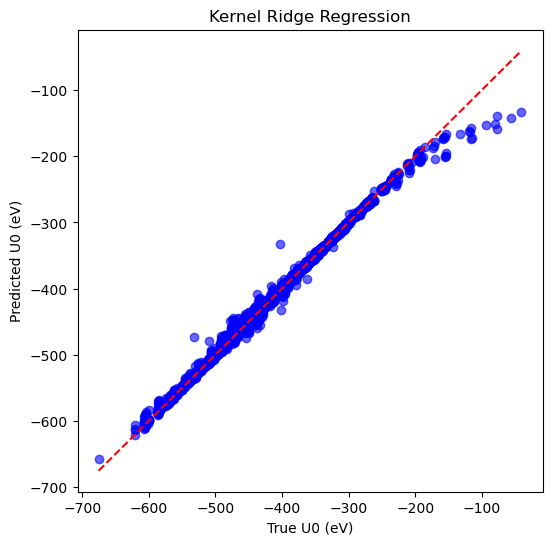

In [23]:
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, y, train_size=0.20)
X_train_norm, X_test_norm = normalize_features(X_train, X_test,checker_model='laplacian')
krr = KernelRidge(kernel='laplacian', alpha=1e-9, gamma=6.103515625e-05)
best_krr = krr.fit(X_train_norm,y_train)
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)

In [25]:
X_train_norm, X_test_norm = normalize_features(X_train, X_test, checker_model='gaussian')

mean_norm: 214.1791300039557


In [26]:
# Train the KRR model with GridSearchCV for laplacian kernel
# manhattan normalization??
best_krr, best_params = train_krr_model(X_train_norm, y_train, alpha=alpha, cv_folds=cv_folds, model_checker='gaussian')

Starting Grid Search for gamma...
Best gamma found: 0.125


Mean Absolute Error: 1.3494
Mean Squared Error: 4.2450
Root Mean Squared Error: 2.0603


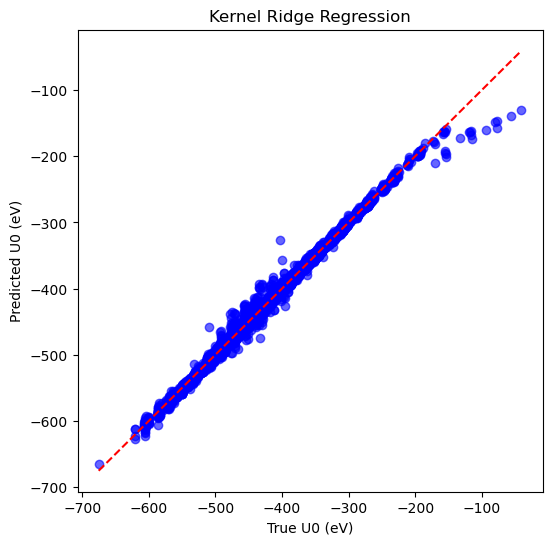

In [27]:
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)

Training set: 26166 samples
Testing set: 104665 samples
mean_norm: 214.0934765661139
Mean Absolute Error: 1.0859
Mean Squared Error: 2.6895
Root Mean Squared Error: 1.6400


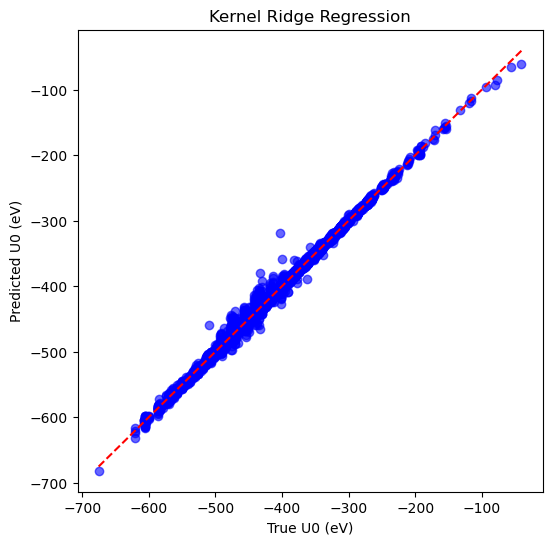

: 

In [28]:
X_train, X_test, y_train, y_test = split_dataset(X, y, train_size=0.20)
X_train_norm, X_test_norm = normalize_features(X_train, X_test,checker_model='gaussian')
krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=0.125)
best_krr = krr.fit(X_train_norm,y_train)
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, y, train_size=0.40)
X_train_norm, X_test_norm = normalize_features(X_train, X_test,checker_model='gaussian')
krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=0.125)
best_krr = krr.fit(X_train_norm,y_train)
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)

Training set: 52332 samples
Testing set: 78499 samples
mean_norm: 213.96919228347645


In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, y, train_size=0.80)
X_train_norm, X_test_norm = normalize_features(X_train, X_test,checker_model='gaussian')
krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=0.125)
best_krr = krr.fit(X_train_norm,y_train)
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)

In [ ]:
X_train, X_test, y_train, y_test = split_dataset(X, y, train_size=0.90)
X_train_norm, X_test_norm = normalize_features(X_train, X_test,checker_model='gaussian')
krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=0.125)
best_krr = krr.fit(X_train_norm,y_train)
mae, mse, rmse, y_pred = evaluate_model(best_krr, X_test_norm, y_test)